# Pylops - Non-stationary convolution

### Author: M.Ravasi

In this notebook we show how to use the ``NonStationaryConvolve1D`` and ``NonStationaryConvolve2D`` operators to perform non-stationary convolution with on-the-fly interpolation between the available filters (which are provided at a coarser grid then the grid of computation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import filtfilt
from scipy.sparse.linalg import lsqr
from numba import jit

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

## 1D

Let's start with a 1D signal. We create two Ricker wavelets, one with frequency of 20Hz and one with frequency of 50Hz and we apply non-stationary convolution with the two filters places at location 201 and 401

(2, 101)

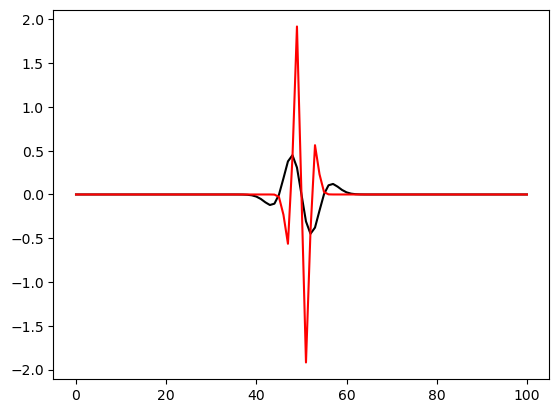

In [2]:
nt = 601
dt = 0.004
t = np.arange(nt)*dt

Dop = FirstDerivative(101)
wav1, _, wav1c = ricker(t[:51], f0=20)
wav2 = ricker(t[:51], f0=50)[0]
wav2 = wav2 * (np.sum(np.abs(wav1)) / np.sum(np.abs(wav2)))

wav1 = Dop @ wav1
wav2 = Dop @ wav2

plt.figure()
plt.plot(wav1, 'k')
plt.plot(wav2, 'r');

wavs = np.stack([wav1, wav2])
wavs.shape

Dot test passed, v^H(Opu)=-69.01489501026595 - u^H(Op^Hv)=-69.01489501026593


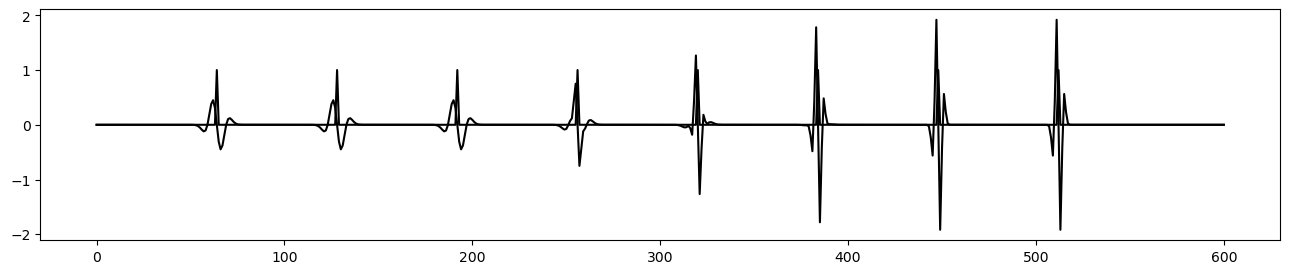

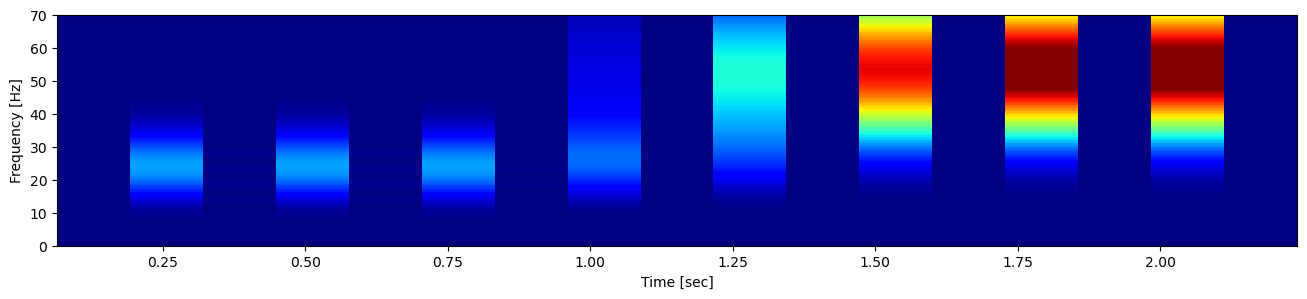

In [3]:
Cop = NonStationaryConvolve1D(dims=nt, hs=wavs, ih=(201, 401))
dottest(Cop, verb=True)

x = np.zeros(nt)
for ix in range(64, nt-64, 64):
    x[ix] = 1.
    
y = Cop @ x

plt.figure(figsize=(16, 3))
plt.plot(x, 'k')
plt.plot(y, 'k')

# spectrogram
f, t1, Sy = sp.signal.spectrogram(y, 1/dt, window=('tukey', 0.4),
                                  nperseg=64, noverlap=32, nfft=2**9, detrend=None,
                                  scaling='spectrum', mode='psd',)

plt.figure(figsize=(16, 3))
plt.pcolormesh(t1, f, Sy, vmax=2e-2, cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 70);

Let's get now the interpolated filters

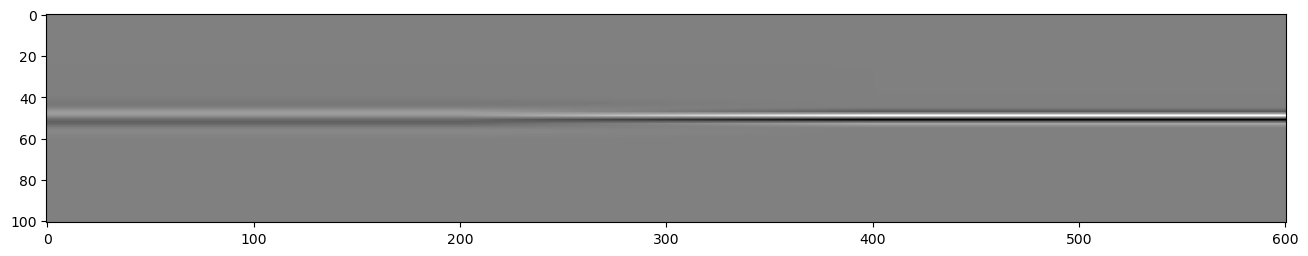

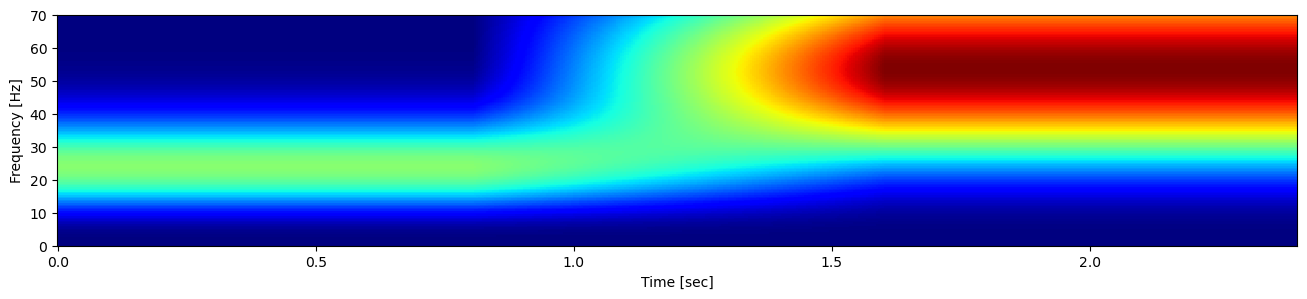

In [4]:
plt.figure(figsize=(16, 3))
plt.imshow(Cop.hsinterp.T, cmap='gray')

# spectra
Sh = np.abs(np.fft.rfft(Cop.hsinterp.T, n=2**9, axis=0))

plt.figure(figsize=(16, 3))
plt.pcolormesh(t, f, Sh,  cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 70);

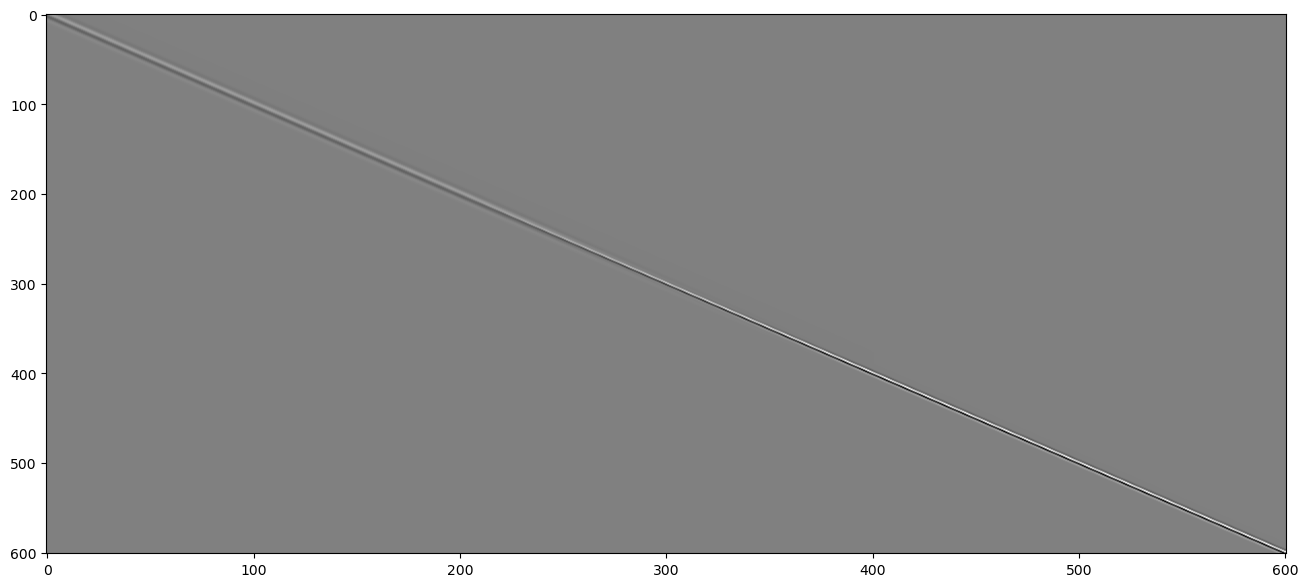

In [5]:
# get dense matrix and check is the same
Cdense = Cop.todense()

plt.figure(figsize=(16, 7))
plt.imshow(Cdense.T, cmap='gray')
plt.axis('tight');

Let's try now to invert this

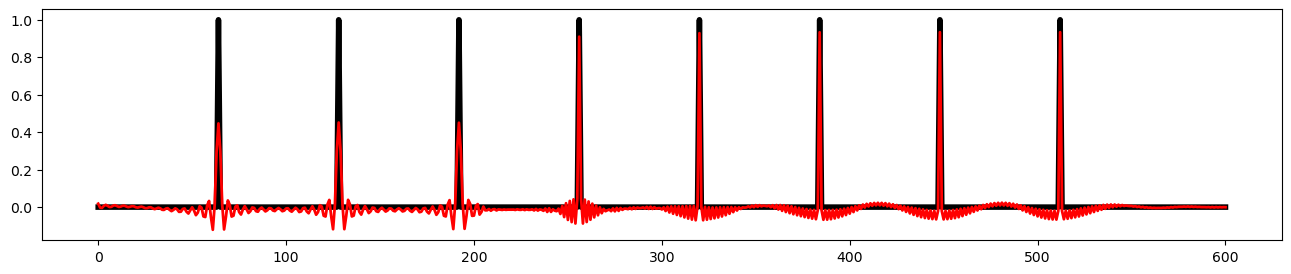

In [6]:
xinv = Cop.div(y, niter=200)

plt.figure(figsize=(16, 3))
plt.plot(x, 'k', lw=4)
plt.plot(xinv, 'r', lw=2);

Finally, we use only one of the two wavelets and check that `NonStationaryConvolve1D` performs stationary convolution (i.e., behaves like `Convolve1D`)

In [7]:
Cop = Convolve1D(h=wav1, offset=wav1c, dims=601)
Copns = NonStationaryConvolve1D(dims=601, hs=np.stack([wav1, wav1]), ih=(201, 401))
Cdense = Cop.todense()

np.allclose(Cop @ x, Copns @ x), np.allclose(Copns @ x, Cdense @ x)

(True, True)

Finally, we do the same with a 2d input signal

Dot test passed, v^H(Opu)=-55.425653628199655 - u^H(Op^Hv)=-55.42565362819957


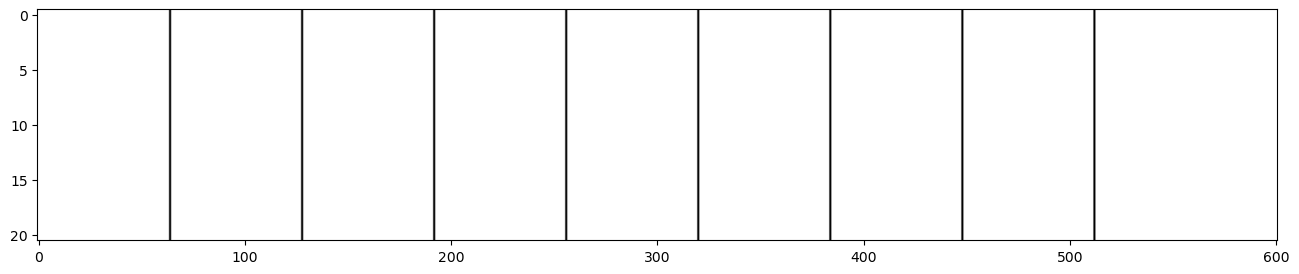

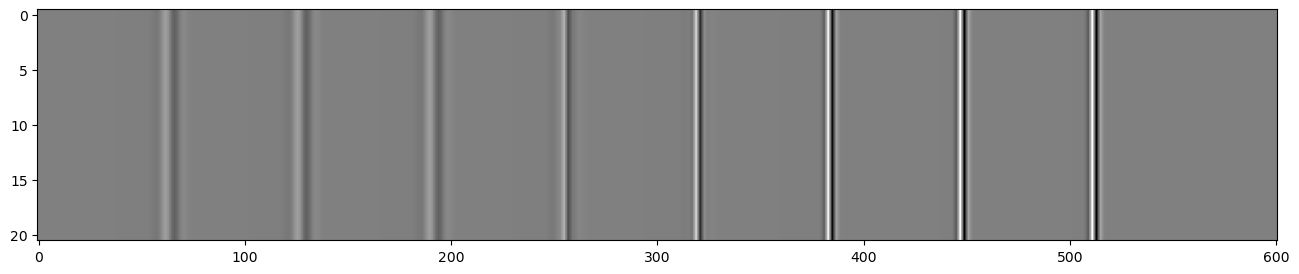

In [8]:
Cop = NonStationaryConvolve1D(dims=(nt, 21), hs=wavs, ih=(201, 401), axis=0)
dottest(Cop, verb=True)

x = np.zeros((nt, 21))
for ix in range(64, nt-64, 64):
    x[ix] = 1.
    
y = Cop @ x
Cop.H @ y

plt.figure(figsize=(16, 3))
plt.imshow(x.T, cmap='gray_r')
plt.axis('tight')
plt.figure(figsize=(16, 3))
plt.imshow(y.T, cmap='gray')
plt.axis('tight');

Dot test passed, v^H(Opu)=-335.41778307955724 - u^H(Op^Hv)=-335.41778307955707


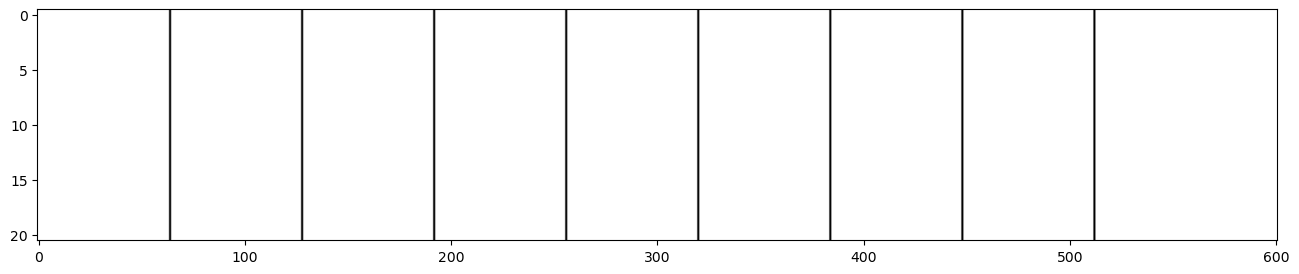

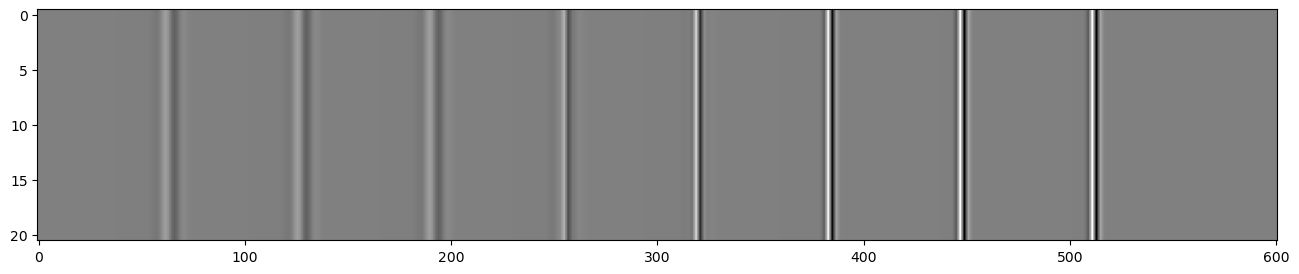

In [9]:
Cop = NonStationaryConvolve1D(dims=(21, nt), hs=wavs, ih=(201, 401), axis=1)
dottest(Cop, verb=True)

x = np.zeros((nt, 21))
for ix in range(64, nt-64, 64):
    x[ix] = 1.
x = x.T

y = Cop @ x
Cop.H @ y

plt.figure(figsize=(16, 3))
plt.imshow(x, cmap='gray_r')
plt.axis('tight')
plt.figure(figsize=(16, 3))
plt.imshow(y, cmap='gray')
plt.axis('tight');

## 2D

We use now 2D filter: in this case, the filters are assumed to be separable in the x-z dimensions and obtained by simple outer product of 2 Ricker wavelet. However, this is not a requirement and any compact 2d filter can be used

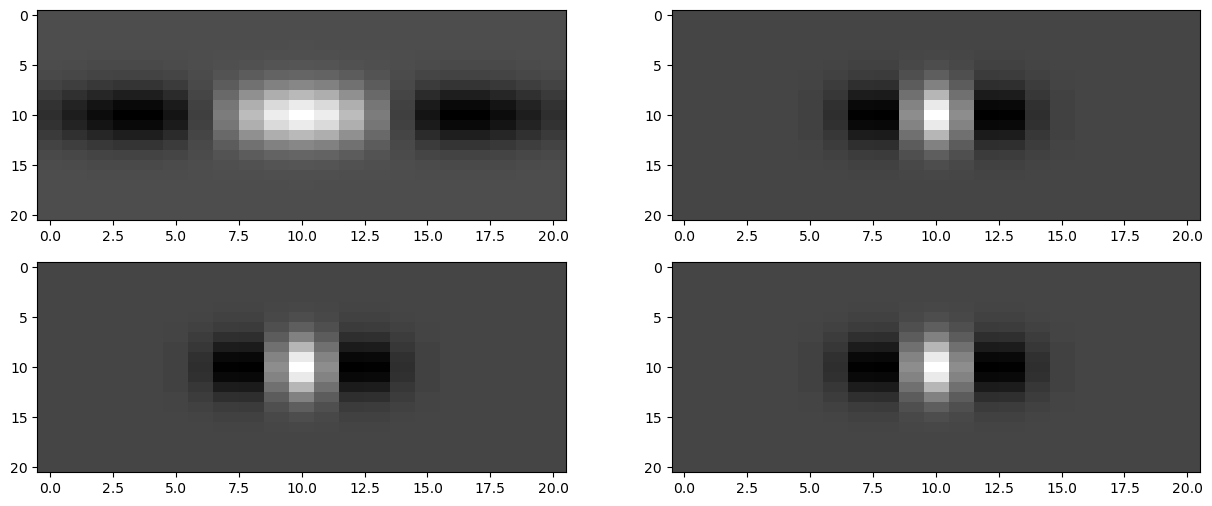

In [10]:
nx, nz = 601, 501

wav1a, _, wav1c = ricker(t[:11], f0=15)
wav1b = ricker(t[:11], f0=40)[0]
wav2 = sp.signal.windows.gaussian(21, 2.)

wav11 = np.outer(wav1a, wav2[np.newaxis]).T
wav12 = np.outer(wav1b, wav2[np.newaxis]).T
wav21 = np.outer(wav1b, wav2[np.newaxis]).T
wav22 = np.outer(wav1b, wav2[np.newaxis]).T
wavsize = wav11.shape

fig, axs = plt.subplots(2, 2, figsize=(15, 6))
axs[0,0].imshow(wav11, 'gray')
axs[0,0].axis('tight')
axs[0,1].imshow(wav12, 'gray')
axs[0,1].axis('tight')
axs[1,0].imshow(wav21, 'gray')
axs[1,0].axis('tight')
axs[1,1].imshow(wav22, 'gray')
axs[1,1].axis('tight');

First, we use only one of the two wavelets and check that `NonStationaryConvolve2D` performs stationary convolution (i.e., behaves like `Convolve2D`)

True

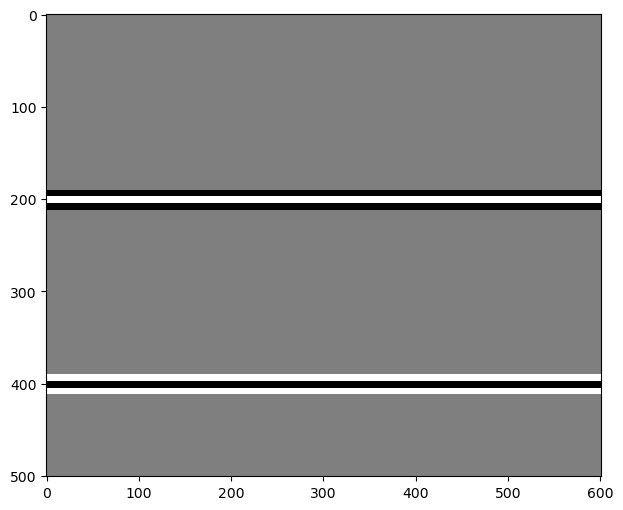

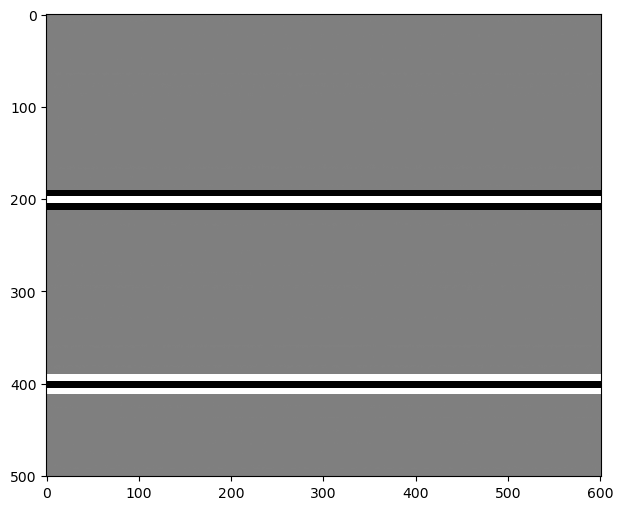

In [11]:
hs = np.zeros((2, 2, *wavsize))
hs[0, 0] = wav11
hs[0, 1] = wav11
hs[1, 0] = wav11
hs[1, 1] = wav11

Cop = NonStationaryConvolve2D(hs=hs, ihx=(201, 401), ihz=(201, 401), dims=(nx, nz), engine="numba")
Copstat = Convolve2D(dims=(nx, nz), h=hs[0, 0], offset=(wavsize[0]//2, wavsize[1]//2))

x = np.zeros((nx, nz))
x[:, 201] = 1.
x[:, 401] = -1.

y = Cop * x
ystat = Copstat * x

plt.figure(figsize=(15, 6))
plt.imshow(y.T, 'gray', vmin=-0.1, vmax=0.1)

plt.figure(figsize=(15, 6))
plt.imshow(ystat.T, 'gray', vmin=-0.1, vmax=0.1)

np.allclose(y, ystat)

Then we move to the non-stationary case

In [12]:
hs = np.zeros((2, 2, *wavsize))
hs[0, 0] = wav11
hs[0, 1] = wav12
hs[1, 0] = wav21
hs[1, 1] = wav22

Copnp = NonStationaryConvolve2D(hs=hs, ihx=(201, 401), ihz=(201, 401), dims=(nx, nz), engine="numpy")
Cop = NonStationaryConvolve2D(hs=hs, ihx=(201, 401), ihz=(201, 401), dims=(nx, nz), engine="numba")
dottest(Copnp, verb=True, atol=1e-1)
dottest(Cop, verb=True, atol=1e-1)

x = np.zeros((nx, nz))
x[:, 201] = 1.
x[:, 401] = -1.

Cop * x #dry-run
%timeit -n1 -r1 Copnp * x
%timeit -n1 -r1 Cop * x


Dot test passed, v^H(Opu)=1801.1964513720673 - u^H(Op^Hv)=1801.196451372065
Dot test passed, v^H(Opu)=-1085.533916872575 - u^H(Op^Hv)=-1085.533916872575
3.94 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
96.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


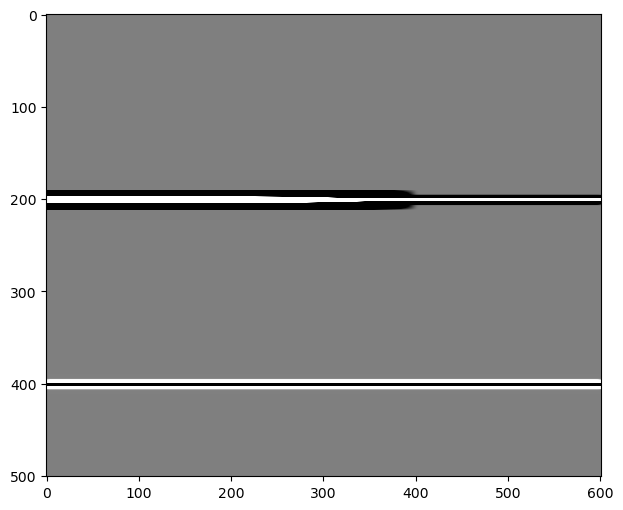

In [13]:
y = Cop * x

plt.figure(figsize=(15, 6))
plt.imshow(y.T, 'gray', vmin=-0.1, vmax=0.1);

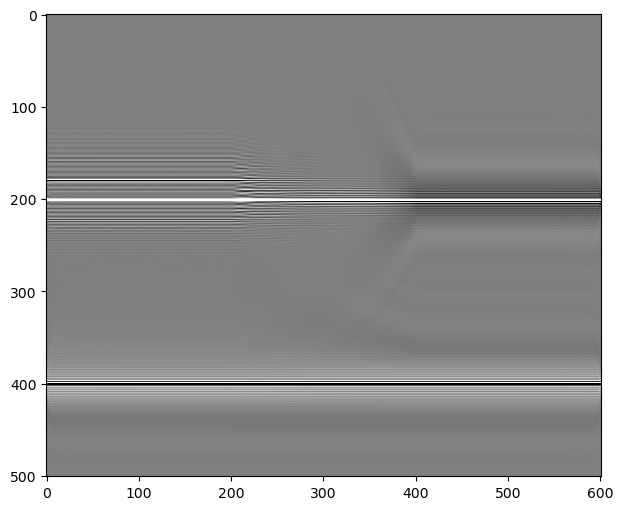

In [14]:
xinv = Cop.div(y.ravel(), niter=100).reshape(x.shape)

plt.figure(figsize=(15, 6))
plt.imshow(xinv.T, 'gray', vmin=-0.1, vmax=0.1);